In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
        
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tqdm import tqdm
from skimage.io import imshow
import tensorflow.keras.utils as np_utils
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix,f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.utils import img_to_array , to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import os
import random
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



In [2]:
def numtoemotion(a):
    match a:
      case 0 | "0":
        return "Irritação"
      case 3 | "3":
        return "Felicidade"
      case 4 | "4":
        return "Tristeza"
      case 5 | "5":
        return "Surpresa"
      case 6 | "6":
        return "Neutralidade"
      case _:
        return "Erro"


Substituindo imutils

In [3]:
image_types = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")


def list_images(basePath, contains=None):
    # return the set of files that are valid
    return list_files(basePath, validExts=image_types, contains=contains)




def list_files(basePath, validExts=None, contains=None):
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if validExts is None or ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename)
                yield imagePath


In [4]:
path_dataset = "/kaggle/input/affectnet/AffectNet/train"

#Carrega a lista de labels
dir = os.listdir(path_dataset)

varname = []
for i in dir:
    if i=="3" or i==3 or i=="4" or i==4:    # if i=="0" or i=="3" or i=="4" or i=="5" or i=="6":
        varname.append(i)
    else:
        continue
print(varname)

['3', '4']


In [5]:
label_dict = {}

for i, d in enumerate(sorted(varname)):
    label_dict[d] = i
    print(d," - ",numtoemotion(d))


print("\n")
print("label_dict: ",label_dict)

#Calcula a quantidade de classes
num_classes = len(label_dict)

print("Número de classes: ", num_classes) # deve dar 5

# neutralidade(6),
# felicidade(3),
# irritação(0),
# surpresa(5)
# tristeza(4)

3  -  Felicidade
4  -  Tristeza


label_dict:  {'3': 0, '4': 1}
Número de classes:  2


In [6]:
# Class dataManager
class dataManager:
    all_img_paths = None
    
    half_train_data = None
    half_train_labels_int = None
    half_train_labels_arr = None
    
    half_test_data = None
    half_test_labels_int = None
    half_test_labels_arr = None

    labels2 = None
    
    def __init__(self,path_dataset): # Inicia all_img_paths com tipo string[n]:
        print("[INFO] Agregando paths das imagens...")
        unorderedImgPaths = list_images(path_dataset)
        
        # unorderedImgPaths virá como '/kaggle/input/affectnet/AffectNet/train/6/image0017435.jpg'
        # Oque estar na pasta 0,3,4,5 e 6 servirá para criar o modelo
        selectedImgPaths = []
        
        for path in unorderedImgPaths:
            match path.split(os.path.sep)[-2]:
                case 3 | "3" | 4 | "4":
                    selectedImgPaths.append(path)
                case _: continue

        assert len(selectedImgPaths) != 0
        
        self.all_img_paths = sorted(list(selectedImgPaths))
        
        random.seed(42)
        random.shuffle( self.all_img_paths )
        print("Verifique os seguintes caminhos: ", self.all_img_paths[-5:])
        print("Quantidade de imagens: ",len(self.all_img_paths))

    #------------------------------------------------------------------------------------
    # Calcula os índices para as divisões
    #  n = len(strings)
    #  quarter = n // 4

    # Divide a lista em quatro partes
    #  parte1 = strings[:quarter]
    #  parte2 = strings[quarter:2*quarter]
    #  parte3 = strings[2*quarter:3*quarter]
    #  parte4 = strings[3*quarter:]
     # self.all_img_paths[inteiro1:inteiro2]
    def load(self): # Carrega metade das imagens na memória, passa elas para array de bytes e divide elas para o treino e teste.
        
        labels = []
        data = []
        none_image = 0
        arrayString = self
        print("[INFO] loading images...")
        quarter = len(self.all_img_paths)//4
        
        
            
        # Carrega a imagem, muda o tamanho e passa ela para array de bytes.
        for imagePath in tqdm(self.all_img_paths):  
            image = cv2.imread(imagePath)
            if image is not None:
                data.append(img_to_array( cv2.resize(image, (224, 224)) ))
                labels.append( label_dict[imagePath.split(os.path.sep)[-2]] )
            else:
                none_image += 1
        
        print(none_image)

        
        # --------------------------------- DIVISÃO PARA TREINO -------------------------------------------
        self.labels2 = np.array(labels)
        # Divisão das imagens para treino e teste.
        (self.half_train_data, self.half_test_data, self.half_train_labels_int, self.half_test_labels_int) = train_test_split( np.array(data, dtype="float") / 255.0,
                                                                                                                              self.labels2,
                                                                                                                              test_size=0.5,
                                                                                                                              random_state=42)
       
        # Converter labels de inteiros para arrays.
        self.half_train_labels = np_utils.to_categorical(self.half_train_labels_int, num_classes=num_classes)
        self.half_test_labels = np_utils.to_categorical(self.half_test_labels_int, num_classes=num_classes)    

        print("[INFO] Divisão de imagens para treino e teste foi terminada.")


In [7]:
# Class Model
class Model:
    model = None
    history = None
    
    def __init__(self):
        self.model = ResNet50(weights='imagenet')
        
    def train(self,dataMan):
        
        self.model.compile(optimizer='adam',
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy'])
        self.history = self.model.fit(dataMan.half_train_data,
                        dataMan.half_test_labels_int,
                        epochs=50,
                        batch_size=10,
                        validation_data=(dataMan.half_test_data, dataMan.half_test_labels_int))

In [8]:
def shoyuMyPics(dataMan,label_dict):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img_float32 = np.float32(dataMan.half_train_data[i])
        plt.imshow(cv2.cvtColor(img_float32, cv2.COLOR_BGR2RGB) )
        # labels
        plt.xlabel( [k for k, v in label_dict.items() if v == dataMan.half_train_labels_int[i]][0] )
    plt.show()


def shoyuMyHistory(modelo):
    plt.plot(modelo.history.history['accuracy'], label='accuracy')
    plt.plot(modelo.history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

def shoyuMyTests(dataMan,modelo):
    print("Generating test predictions...")
    predict_x=modelo.model.predict(dataMan.half_train_data)
    print(np.around(predict_x, 2))

    # make class predictions
    predictions = (predict_x > 0.5).astype(int)

    y_pred_class = np.argmax(predictions, axis=1)
    y_test_class = np.argmax(dataMan.half_test_labels, axis=1)

    #for i in range(len(dataMan.half_test_labels)):
    #	if y_pred_class[i] == y_test_class[i]:
    #		print(f'\033[92m {y_pred_class[i]} (expected {y_test_class[i]})')
    #	else:
    #		print(f'\033[91m {y_pred_class[i]} (expected {y_test_class[i]})')

    return y_pred_class, y_test_class,predictions


def shoyuMyGrades(y_test_class, y_pred_class):
    l = len(y_test_class)
    y_test2 = y_test_class
    y_pred2 = y_pred_class
    acc = sum([y_pred_class[i]==y_test_class[i] for i in range(l)])/l
    print('Accuracy: %.2f %%' % (acc*100))
    return acc


def shoyuMyConfusion(dataMan,predictions):
    # voltando pro formato de classes
    y_pred = np.argmax(predictions, axis=1)
    y_test_c = np.argmax(dataMan.half_test_labels, axis=1)




[INFO] Agregando paths das imagens...
Verifique os seguintes caminhos:  ['/kaggle/input/affectnet/AffectNet/train/3/image0008782.jpg', '/kaggle/input/affectnet/AffectNet/train/3/image0009621.jpg', '/kaggle/input/affectnet/AffectNet/train/3/image0010861.jpg', '/kaggle/input/affectnet/AffectNet/train/3/image0001011.jpg', '/kaggle/input/affectnet/AffectNet/train/3/image0004386.jpg']
Quantidade de imagens:  10000
[INFO] loading images...


100%|██████████| 10000/10000 [01:18<00:00, 126.74it/s]


0
[INFO] Divisão de imagens para treino e teste foi terminada.


-------------------------------------------------------------------------------------




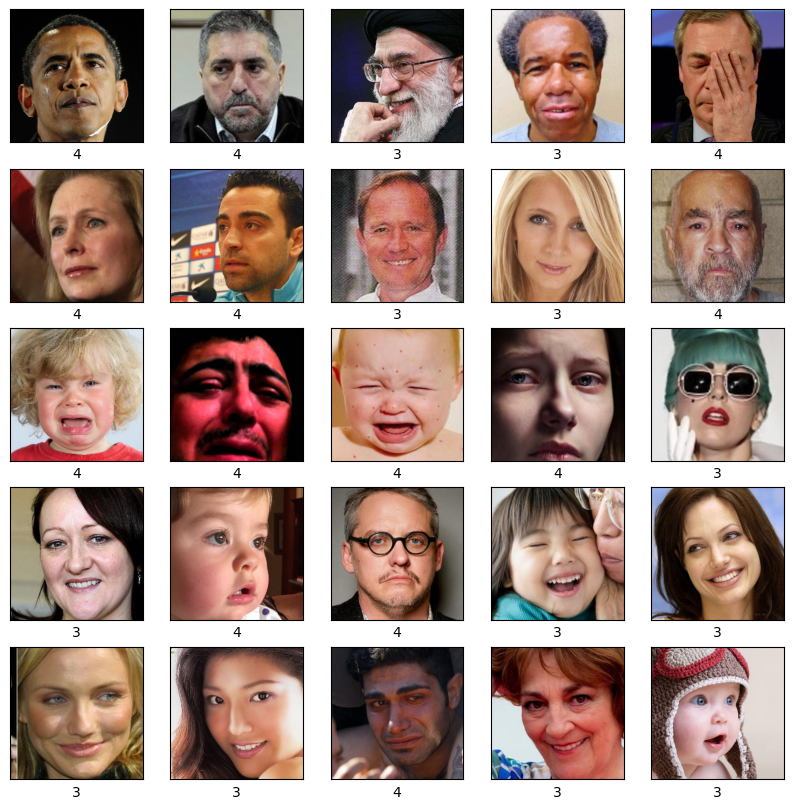



-------------------------------------------------------------------------------------


102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
I0000 00:00:1733164238.988817      94 service.cc:145] XLA service 0x7a14200045a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733164238.989484      94 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/500 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.0000e+00 - loss: 7.6132   

I0000 00:00:1733164260.821159      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 107s 114ms/step - accuracy: 0.4904 - loss: 1.1568 - val_accuracy: 0.4968 - val_loss: 0.8932
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 91ms/step - accuracy: 0.5151 - loss: 0.7137 - val_accuracy: 0.4522 - val_loss: 0.7002
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 91ms/step - accuracy: 0.5075 - loss: 0.7100 - val_accuracy: 0.5070 - val_loss: 0.7016
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 90ms/step - accuracy: 0.4850 - loss: 0.7069 - val_accuracy: 0.4846 - val_loss: 0.6983
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 90ms/step - accuracy: 0.5304 - loss: 0.6973 - val_accuracy: 0.4520 - val_loss: 0.7046
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 90ms/step - accuracy: 0.5098 - loss: 0.7008 - val_accuracy: 0.5432 - val_loss: 0.9213
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 90ms/step - accuracy: 0.5157 - loss: 0.6986 - val_accuracy: 0.4492 - val_loss: 0.7228
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 90ms/step - accuracy: 0.5035 - loss: 0.6993 - val_accur

In [ ]:
index = 1
dataMan = dataManager(path_dataset)


while index < num_classes:
    if index != 1:
        dataMan().half_train_data = None
        dataMan().half_train_labels_int = None
        dataMan().half_train_labels_arr = None
    
        dataMan().half_test_data = None
        dataMan().half_test_labels_int = None
        dataMan().half_test_labels_arr = None

        dataMan().labels2 = None
    
    dataMan.load()
    
    print("\n")
    print("-------------------------------------------------------------------------------------")
    print("\n")
    
    
    shoyuMyPics(dataMan,label_dict)
    
    print("\n")
    print("-------------------------------------------------------------------------------------")
    print("\n")
    
    modelo = Model()
    modelo.train(dataMan)
    
    print("\n")
    print("-------------------------------------------------------------------------------------")
    print("\n")
    
    shoyuMyHistory(modelo)
    
    print("\n")
    print("-------------------------------------------------------------------------------------")
    print("\n")
    
    YPred, yTest, predickson = shoyuMyTests(dataMan,modelo)
    
    print("\n")
    print("-------------------------------------------------------------------------------------")
    print("\n")
    
    acc = shoyuMyGrades(yTest,ypred)
    
    print("\n")
    print("-------------------------------------------------------------------------------------")
    print("\n")
    
    shoyuMyConfusion(dataMan,predickson)
    
    print("\n")
    print("-------------------------------------------------------------------------------------")
    print("\n")

    if index == num_classes-1:
        model.save(r'./kaggle/working/dice2emotions.hdf5')
    
    index = index + 1
    
    